In [ ]:
def retrieve_data(file_path):
    with open(file_path, 'r') as file:
        data = file.read().splitlines()
    
    #

In [564]:
# Read in the file
with open("../robot_position.txt", "r") as f:
    lines = f.readlines()
    for line in lines[:5]:
        print(line.strip())

start -> translation: (0.96, 0.492, 0.05)| rotation: (0.0, 0.0, 1.0, 0.0)
x: 0.0, y: 0.0
x: 1.34954688, y: 0.0
x: 3.2992608, y: 0.0
x: 3.386489614720858, y: 0.026886114419862436


In [565]:
# Extract position data
data = []
start = None
for line in lines:
    if "start" in line:
        split_line = line.split("->")[1].split("|")
        translation_data = [float(x) for x in split_line[0].split(":")[1].strip().strip("(").strip(")").split(",")]
        rotation_data = [float(x) for x in split_line[1].split(":")[1].strip().strip("(").strip(")").split(",")]
        start = {
            "translation": translation_data,
            "rotation": rotation_data,
        }
        continue
    split_line = line.split(",")
    x = float(split_line[0].split(":")[1])
    y = float(split_line[1].split(":")[1])
    data.append((x, y))

data[:5]

[(0.0, 0.0),
 (1.34954688, 0.0),
 (3.2992608, 0.0),
 (3.386489614720858, 0.026886114419862436),
 (2.734104383631756, 1.0358560577352967)]

In [566]:
start

{'translation': [0.96, 0.492, 0.05], 'rotation': [0.0, 0.0, 1.0, 0.0]}

In [567]:
import numpy as np
# If start data exists, offset all the points by the translation
# Then rotate the points by the rotation
if start:
    # Use Webot starting translation and rotation data
    translation = start['translation']
    rotation_angle = start['rotation'][3]  # -1.57 (rotation angle in radians)

    # Offset translation
    data = [
        (
            (x - translation[0]),
            (y - translation[1])
        )
        for x, y in data
    ]

    # Apply 2D rotation matrix for the angle
    cos_angle = np.cos(rotation_angle)
    sin_angle = np.sin(rotation_angle)
    
    data = [
        (
            x * cos_angle - y * sin_angle,
            x * sin_angle + y * cos_angle
        )
        for x, y in data
    ]

In [585]:
data[:5]

array([[-0.96      , -0.492     ],
       [ 0.38954688, -0.492     ],
       [ 2.3392608 , -0.492     ],
       [ 2.42648961, -0.46511389],
       [ 1.77410438,  0.54385606]])

In [586]:
min_x = min([x for x, y in data])
max_x = max([x for x, y in data])
min_y = min([y for x, y in data])
max_y = max([y for x, y in data])

print(f"({min_x}, {min_y}), ({max_x}, {max_y})")

(-1.2523029940816097, -0.6282638353441057), (8.343676709632515, 8.864481211775637)


In [568]:
# !pip install matplotlib numpy

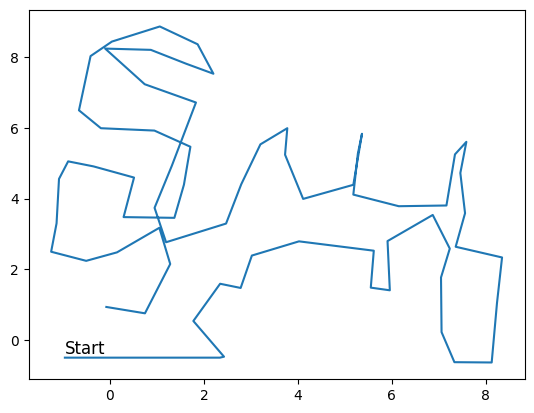

In [569]:
import matplotlib.pyplot as plt
import numpy as np

data = np.array(data)
plt.plot(data[:, 0], data[:, 1])
# Label Point 0 as "Start"
plt.text(data[0, 0], data[0, 1], "Start", fontsize=12, verticalalignment='bottom')
plt.show()

In [570]:
map_image_path = "apartment.jpg"

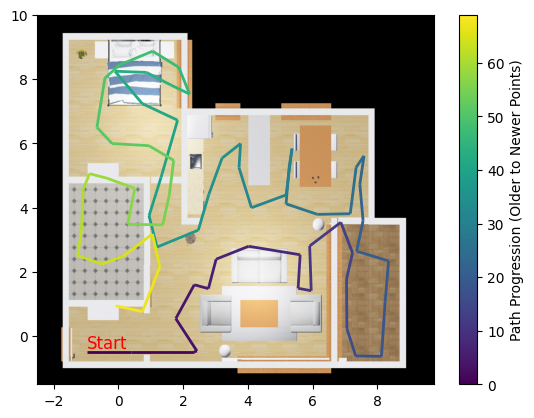

In [603]:
# Plot the data with the background image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

# Load the image
img = plt.imread(map_image_path)

# Create a figure and axis
fig, ax = plt.subplots()

# Display the background image
# extent specifies the left, right, bottom, and top sides of the image.
# Ensure that the extent covers the range of the data appropriately.
# ax.imshow(img, extent=[data[:, 0].min(), data[:, 0].max(), data[:, 1].min(), data[:, 1].max()], aspect='auto')
bottom_left = (-2.5, -1.5)
top_right = (9.75, 10)

ax.imshow(img, extent=[bottom_left[0], top_right[0], bottom_left[1], top_right[1]], aspect='auto')

# Convert your data to a NumPy array
data = np.array(data)

# Create a color gradient for the path
points = np.array([data[:, 0], data[:, 1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Normalize colors over the length of the data
norm = Normalize(vmin=0, vmax=len(data)-1)
colors = plt.cm.viridis(norm(np.arange(len(data))))

# Create a line collection with gradient
lc = LineCollection(segments, cmap='viridis', norm=norm, linewidth=2)
lc.set_array(np.arange(len(data)))

# Add the line collection to the axis
line = ax.add_collection(lc)

# Label the start point
ax.text(data[0, 0], data[0, 1], "Start", fontsize=12, verticalalignment='bottom', color="red")

# Add color bar to show the gradient scale
cbar = plt.colorbar(line, ax=ax)
cbar.set_label("Path Progression (Older to Newer Points)")

# Set limits based on the data
ax.set_xlim([min(bottom_left[0], data[:, 0].min()), max(top_right[0], data[:, 0].max())])
ax.set_ylim([min(bottom_left[1], data[:, 1].min()), max(top_right[1], data[:, 1].max())])

# Display the plot
plt.show()
